In [1]:
import os,sys
import datetime
import scanpy as sc
import numpy as np
import pandas as pd

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches
import json
import scipy

In [330]:
import matplotlib as mpl
mpl.rc('font',family='Arial')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['axes.linewidth'] = 0.5
mpl.rcParams['lines.linewidth'] = 0.5

## Load labels only

For this analysis, only cell type abundance within samples is needed so no need to load the expression data. 
Calculations are performed as described in Chan et al., 2021 (https://doi.org/10.1016/j.ccell.2021.09.008)

In [6]:
#load latest obs
filename = 'backups_JZ_2022/corrected_obs_info_50236x32_221012_12h04.npz'
encoding = 'latin1'

with np.load(filename,encoding=encoding, allow_pickle = True) as f:
    obs = pd.DataFrame(**f)


In [8]:
obs.keys()

Index(['library', 'total_counts', 'pct_counts_mito', 'library2', 'sample',
       'patient', 'pT stage', 'seq_date', 'beads', 'operation', 'sex',
       'tumor size, mm', 'age', 'tissue', 'necrosis', 'doublet_score',
       'potential_doublet', 'top3pct_dbtl_score', 'top5pct_dbtl_score',
       'top10pct_dbtl_score', 'closest_JZ_kidney', 'closest_JZ_kidney_hvg',
       'n_counts', 'no_dblt_no_rbc', 'sp_cl_43', 'cell_type',
       'broad_cell_type', 'color', 'cell_group', 'stage_color',
       'patient_color', 'group_color'],
      dtype='object')

### Excluding patient-specific Tumor cells 1 and healthy tissue, calculating entropy for tumor samples

In [312]:
tissue_mask = ~obs['tissue'].isin(['Healthy'])
exclude_tumorc1 = ~obs['cell_type'].isin(['Tumor cells 1'])


In [313]:
obs_filt = obs[exclude_tumorc1&tissue_mask]

In [323]:
cell_type_entropy_dict = {}

for cellgroup in obs_filt['cell_group'].unique():
    key = cellgroup
    cmask = obs_filt['cell_group'].isin([cellgroup])
    
    if cmask.sum()>1000:
        df_to_sample = obs_filt[cmask]
        entropy_values = []
        for i in range(0, 100):
        
            random_sample_pt = df_to_sample.sample(n=100)['sample']
        
            qk = np.array(random_sample_pt.value_counts(normalize=True))
        
            entropy = scipy.stats.entropy(qk)
            entropy_values.append(entropy)
        cell_type_entropy_dict[key]=entropy_values
    

In [324]:
obs_filt['cell_group'].value_counts()

Lymphoid cells    18569
Myeloid cells      9848
Endothelium        4543
Tumor cells        2882
Stromal            2434
Cycling             516
Epithelial          173
Name: cell_group, dtype: int64

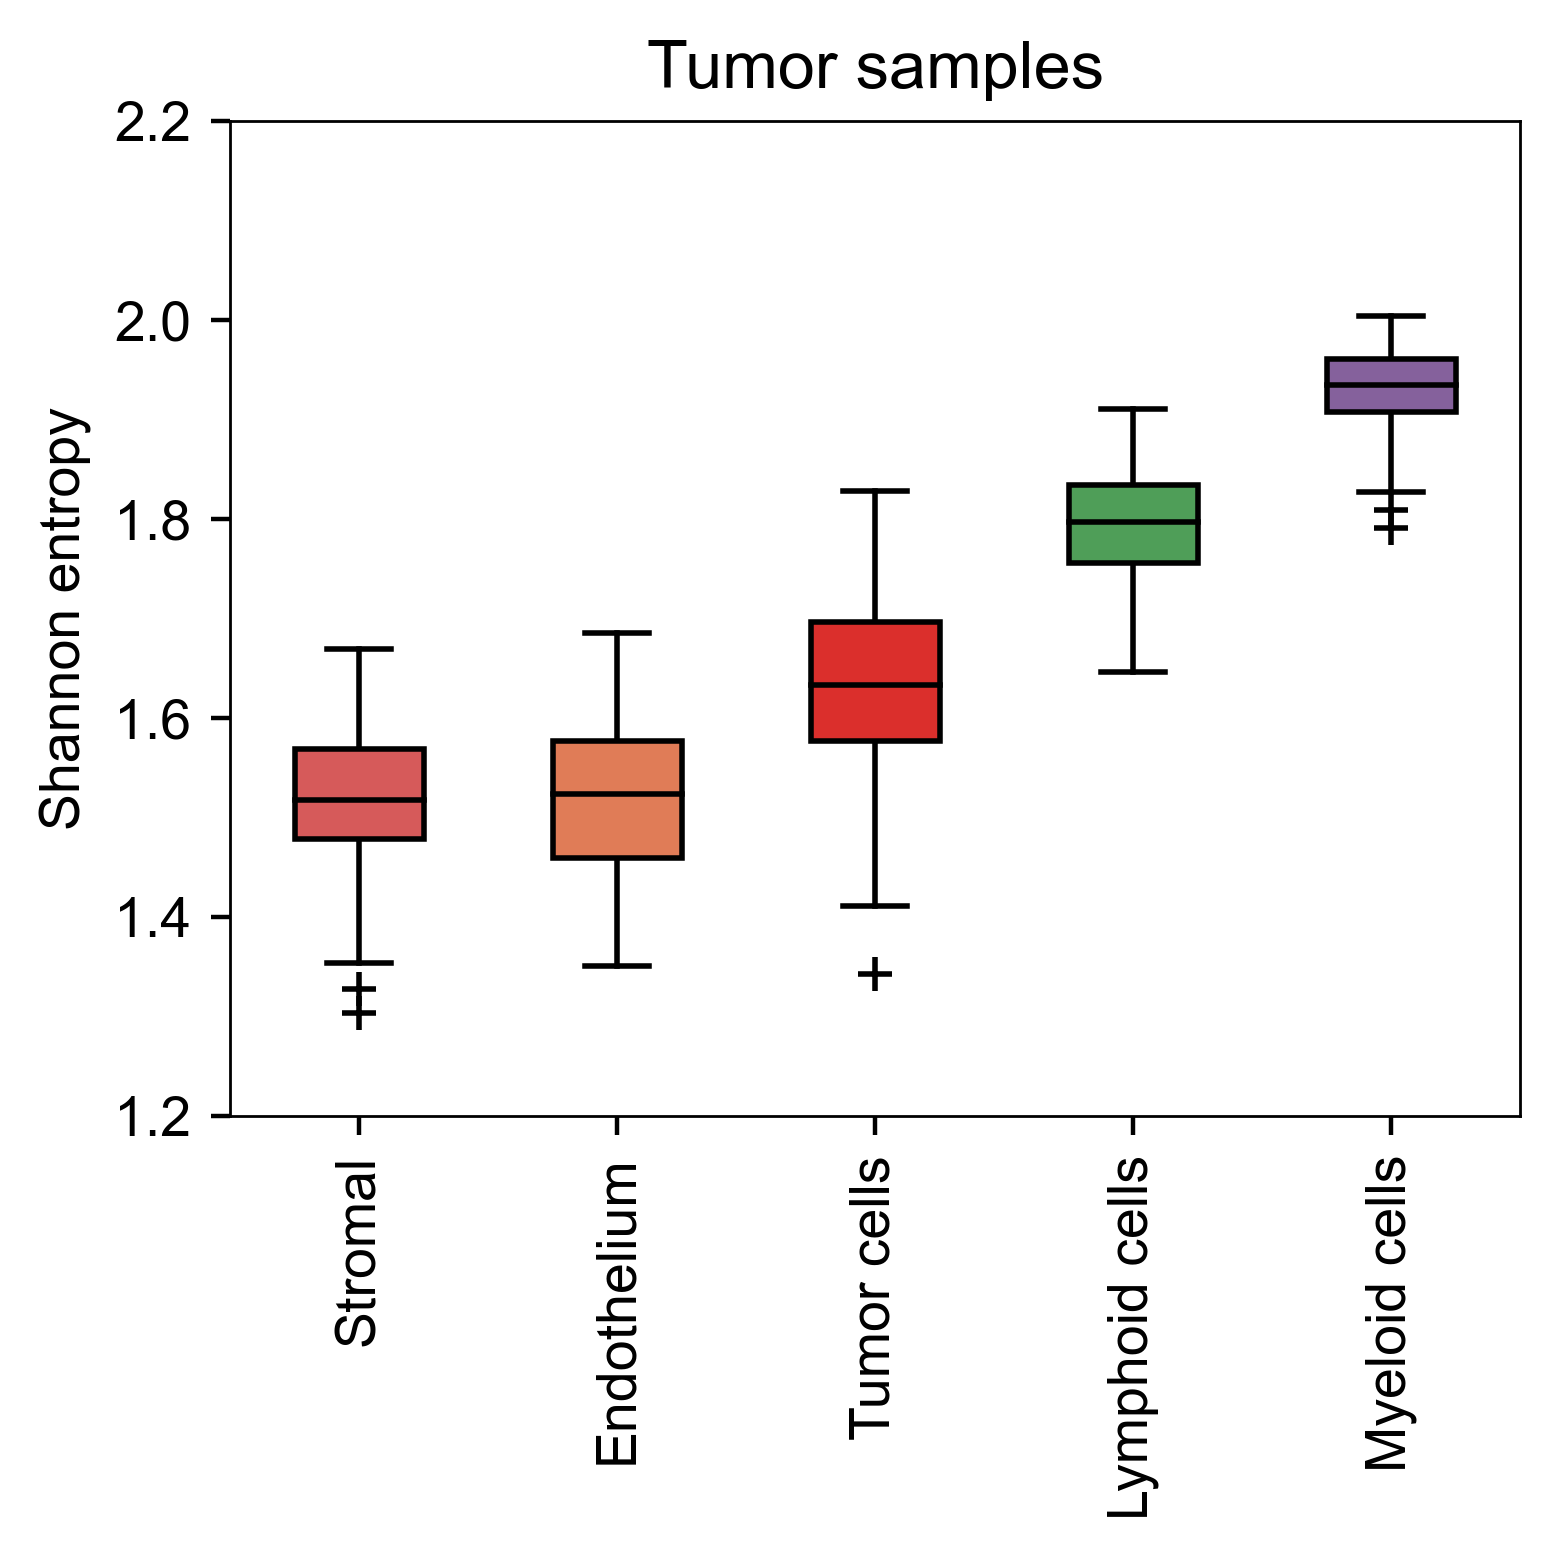

In [343]:
cell_type_entropy_dict

names = list(cell_type_entropy_dict.keys())
values = list(cell_type_entropy_dict.values())

medians  = [np.median(i) for i in values]
order = np.argsort(medians)
sorted_list = [values[i] for i in order]
sorted_names = [names[i] for i in order]

fig, ax = plt.subplots(figsize=(4, 4), frameon=False, dpi=400)
ax = plt.boxplot(sorted_list, labels=sorted_names, patch_artist=True, sym = '+')

plt.ylabel('Shannon entropy')

color_dict = dict(zip(obs['cell_group'], obs["group_color"]))

color_list = [color_dict[i] for i in sorted_names]
for patch, color in zip(ax['boxes'], color_list):
        patch.set_facecolor(color)
        
for median in ax['medians']:
    median.set_color('black')
plt.ylim([1.2, 2.2])
plt.xticks(rotation=90)
plt.title('Tumor samples')
plt.tight_layout()
plt.savefig('figures_paper/tumor_entropy.pdf')

## Same for healthy adjacent samples

In [303]:
tissue_mask = ~obs['tissue'].isin(['Tumor'])
exclude_tumorc1 = ~obs['cell_type'].isin(['Tumor cells 1'])


In [304]:
obs_filt_h = obs[exclude_tumorc1&tissue_mask]

In [305]:
obs_filt_h['cell_type'].value_counts()

Proximal tubule                     5499
AVR                                  909
Resting/memory T cells               659
Glomerular endothelium               486
TAL of LOH                           380
NK cells                             295
DVR                                  289
Epithelial progenitor-like cells     280
vSMCs                                261
Non-classical monocytes              185
Principal cells                      181
Classical monocytes                  177
TAM 3                                156
Type A-ICs                           152
Mesangial/vSMCs                      132
OM Type A-ICs                        121
DCT/CNT                              120
Tumor vasculature 4                  114
TAM 1                                 81
TAM 4                                 79
Type B-IC                             78
tAL of LOH                            75
CD8 T cells                           71
Cytotoxic T cells                     66
B cells         

In [306]:
cell_type_entropy_dict_h = {}

for cellgroup in obs_filt_h['cell_group'].unique():
    key = cellgroup
    cmask = obs_filt_h['cell_group'].isin([cellgroup])
    
    if cmask.sum()>100:
        df_to_sample = obs_filt_h[cmask]
        entropy_values = []
        for i in range(0, 100):
        
            random_sample_pt = df_to_sample.sample(n=100)['sample']
        
            qk = np.array(random_sample_pt.value_counts(normalize=True))
        
            entropy = scipy.stats.entropy(qk)
            entropy_values.append(entropy)
        cell_type_entropy_dict_h[key]=entropy_values
    

In [307]:
obs_filt_h['cell_group'].value_counts()

Epithelial        6929
Endothelium       1851
Lymphoid cells    1193
Myeloid cells      719
Stromal            412
Tumor cells         31
Cycling             10
Name: cell_group, dtype: int64

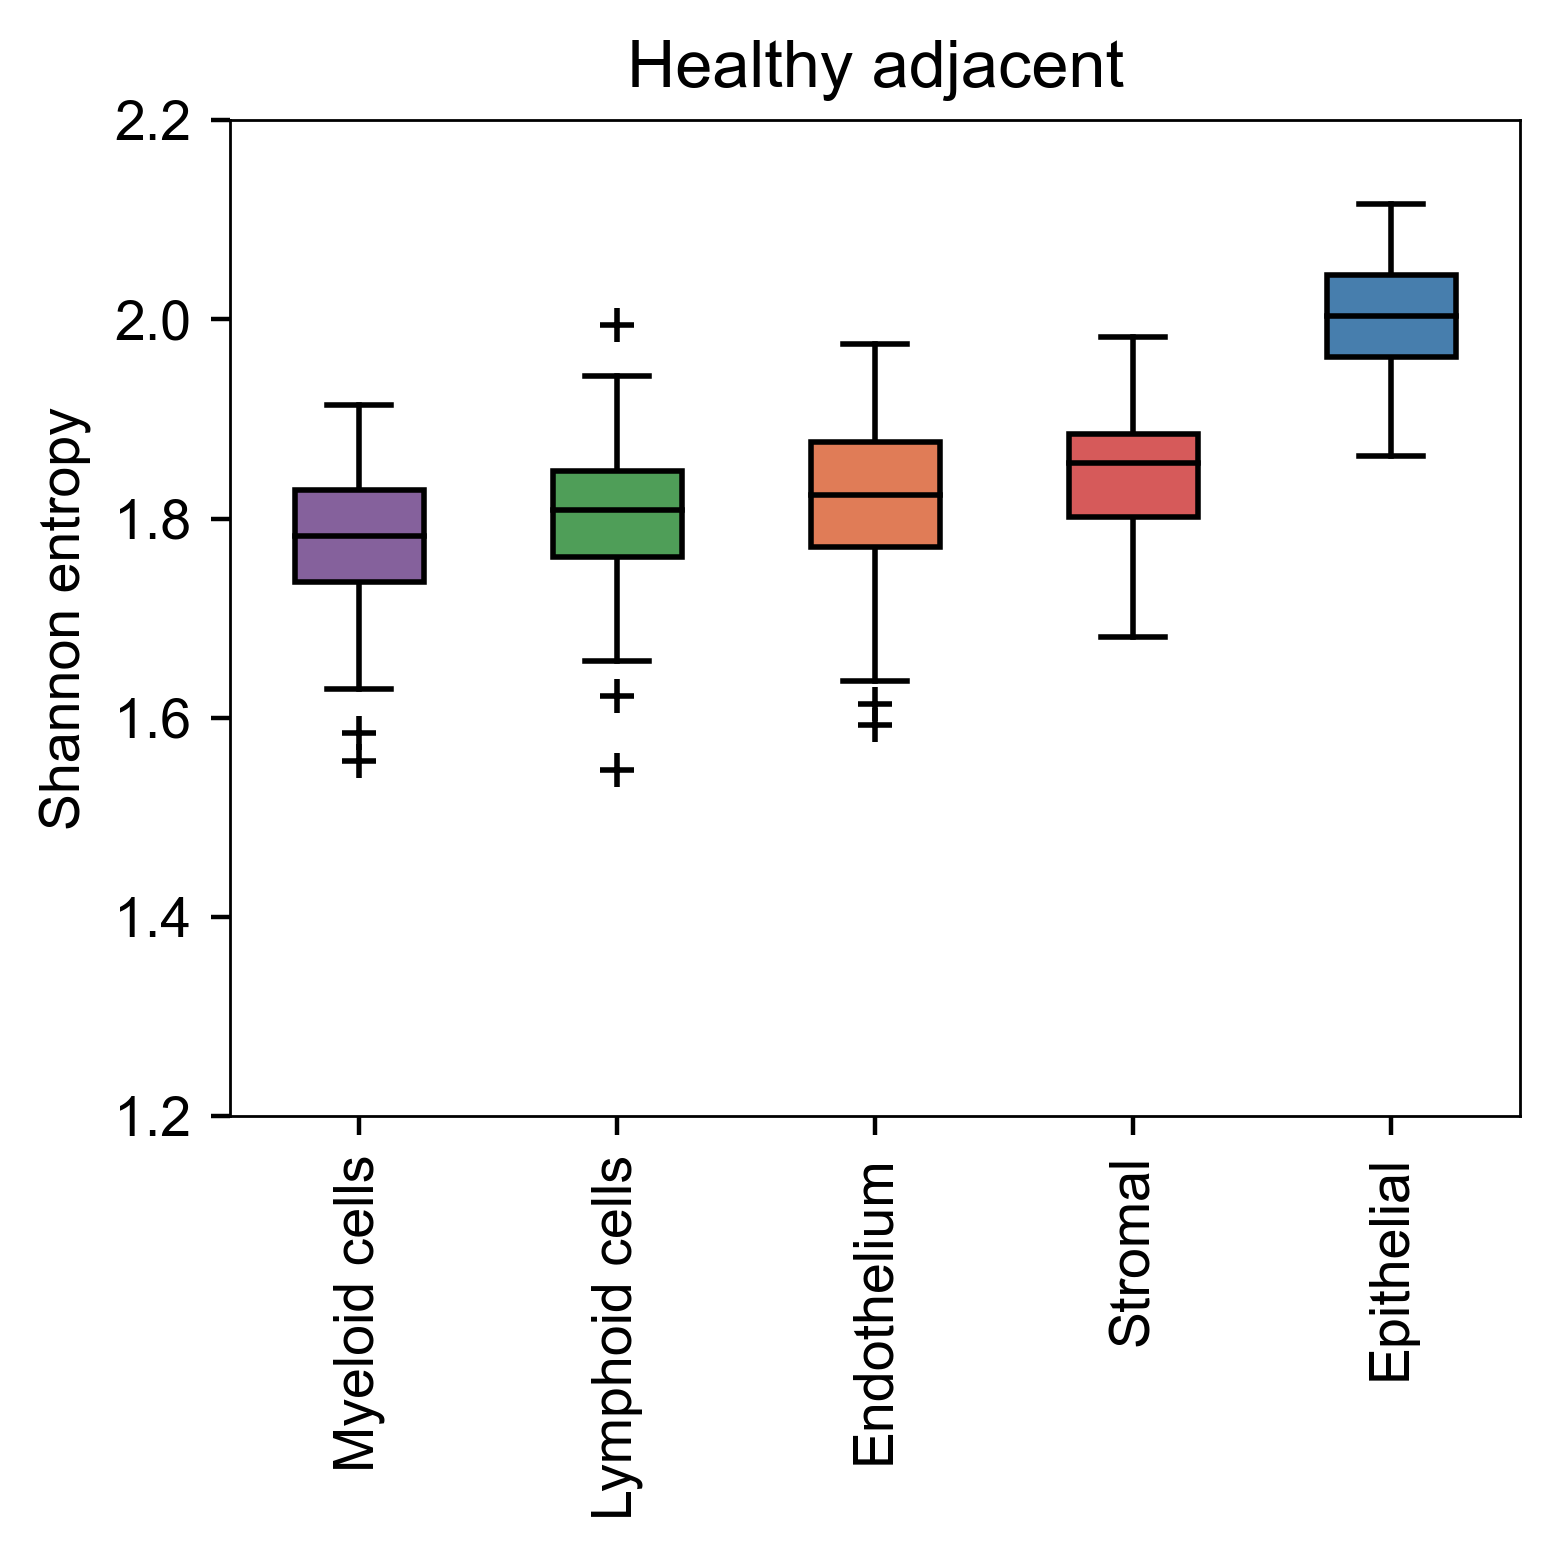

In [342]:


names = list(cell_type_entropy_dict_h.keys())
values = list(cell_type_entropy_dict_h.values())

medians  = [np.median(i) for i in values]
order = np.argsort(medians)
sorted_list = [values[i] for i in order]
sorted_names = [names[i] for i in order]

fig, ax = plt.subplots(figsize=(4, 4), frameon=False, dpi=400)
ax = plt.boxplot(sorted_list, labels=sorted_names, patch_artist=True, sym = '+')

plt.ylabel('Shannon entropy')

color_dict = dict(zip(obs['cell_group'], obs["group_color"]))

color_list = [color_dict[i] for i in sorted_names]
for patch, color in zip(ax['boxes'], color_list):
        patch.set_facecolor(color)
        
for median in ax['medians']:
    median.set_color('black')

plt.ylim([1.2, 2.2])
plt.title('Healthy adjacent')
plt.xticks(rotation=90)

plt.tight_layout()
plt.savefig('figures_paper/healthy_entropy.pdf')